# Final Project

In [1]:
import pandas as pd

In [2]:
# Set display options to avoid truncation
import pandas as pd

# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows (adjust if needed, can use 'None' for no limit)
pd.set_option('display.max_rows', None)

# Set the maximum width of each column (adjust if needed)
pd.set_option('display.max_colwidth', None)

In [3]:
def load_movie_lines(lines_file_path):
    lines = {}
    with open(lines_file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split(' +++$+++ ')
            if len(parts) == 5:
                line_id, character_id, movie_id, character_name, text = parts 
                lines[line_id] = {
                    "character_id": character_id,
                    "movie_id": movie_id,
                    "character_name": character_name,
                    "text": text
                }
    return lines
        

In [4]:
def load_movie_conversations(conversations_file_path):
    conversations = []
    with open(conversations_file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split(' +++$+++ ')
            if len(parts) == 4:
                character1_id, character2_id, movie_id, utterance_ids = parts
                utterance_ids = utterance_ids[1:-1].replace("'", "").split(', ')
                conversations.append({
                    "character1_id": character1_id,
                    "character2_id": character2_id,
                    "movie_id": movie_id,
                    "utterances": utterance_ids
                })
    return conversations

In [5]:
def load_movie_metadata(metadata_file_path):
    movie_metadata = {}
    with open(metadata_file_path, 'r', encoding='utf-8', errors='ignore') as f: 
        for line in f:
            parts = line.strip().split(' +++$+++ ')
            if len(parts) > 5:
                movie_id, title, genre = parts[0], parts[1], parts[5]
                movie_metadata[movie_id] = genre
    return movie_metadata

In [6]:
lines_file = "./Cornell_Movie_Dialogue_Corpus/movie_lines.txt"
conversation_file = "./Cornell_Movie_Dialogue_Corpus/movie_conversations.txt"
metadata_file = "./Cornell_Movie_Dialogue_Corpus/movie_titles_metadata.txt"

lines = load_movie_lines(lines_file)
conversations = load_movie_conversations(conversation_file)
movie_metadata = load_movie_metadata(metadata_file)

In [7]:
# Build character ID to name mapping
character_id_to_name = {}

for line in lines.values():
    character_id = line['character_id']
    character_name = line['character_name']
    character_id_to_name[character_id] = character_name

# Initialize empty list to store conversation data
data = []

# Set the maximum history length
MAX_HISTORY_LENGTH = 5

# Define a special token for empty history
EMPTY_HISTORY_TOKEN = "[START]"

# Loop through each conversation block
for conv in conversations:
    utterance_ids = conv['utterances']
    character1_id = conv['character1_id']
    character2_id = conv['character2_id']
    character1_name = character_id_to_name.get(character1_id)
    character2_name = character_id_to_name.get(character2_id)

    # Skip conversation if character names are missing
    if not character1_name or not character2_name:
        continue

    # Initialize full conversation history
    full_conversation_history = []

    # Loop through the utterances to build conversation history and response for each block
    for i in range(len(utterance_ids)):
        response_id = utterance_ids[i]  # Current response ID

        # Ensure the response_id is in the lines dictionary
        if response_id in lines:
            response_line = lines[response_id]
            response = response_line['text']
            character_2 = response_line['character_name']  # Current speaker

            # Determine character_1 as the other character in the conversation
            if character_2 == character1_name:
                character_1 = character2_name
            else:
                character_1 = character1_name

            # Build the conversation history using a sliding window
            start_idx = max(0, i - MAX_HISTORY_LENGTH)
            history_ids = utterance_ids[start_idx:i]

            # Check if history is empty
            if not history_ids:
                conversation_history = [EMPTY_HISTORY_TOKEN]
            else:
                conversation_history = [lines[utt_id]['text'] for utt_id in history_ids if utt_id in lines]

            # Determine the history length, setting it to 0 if [START] is in conversation_history
            if conversation_history == [EMPTY_HISTORY_TOKEN]:
                history_length = 0
            else:
                history_length = len(conversation_history)

            # Append the conversation and its context to the data
            data.append({
                "movie_id": conv['movie_id'],
                "character_1": character_1,  # Person being addressed
                "character_2": character_2,  # Current speaker
                "conversation_history": conversation_history,
                "history_length": history_length,
                "response": response,
                "genre": movie_metadata.get(conv['movie_id'], [])
            })

            # Update full conversation history
            full_conversation_history.append(response)
        else:
            continue  # Skip if the response_id is missing in lines


In [8]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Add Genre as meta data
df['genre'] = df['movie_id'].map(movie_metadata)

# Display the DataFrame
#df.head(130:140)
df.iloc[128:141]

,movie_id,character_1,character_2,conversation_history,history_length,response,genre
128,m0,BIANCA,KAT,[[START]],0,"Joey never told you we went out, did he?","['comedy', 'romance']"
129,m0,KAT,BIANCA,"[Joey never told you we went out, did he?]",1,What?,"['comedy', 'romance']"
130,m0,BIANCA,KAT,"[Joey never told you we went out, did he?, What?]",2,In 9th. For a month,"['comedy', 'romance']"
131,m0,KAT,BIANCA,"[Joey never told you we went out, did he?, What?, In 9th. For a month]",3,Why?,"['comedy', 'romance']"
132,m0,BIANCA,KAT,"[Joey never told you we went out, did he?, What?, In 9th. For a month, Why?]",4,"He was, like, a total babe","['comedy', 'romance']"
133,m0,KAT,BIANCA,"[Joey never told you we went out, did he?, What?, In 9th. For a month, Why?, He was, like, a total babe]",5,But you hate Joey,"['comedy', 'romance']"
134,m0,BIANCA,KAT,"[What?, In 9th. For a month, Why?, He was, like, a total babe, But you hate Joey]",5,"Now I do. Back then, was a different story.","['comedy', 'romance']"
135,m0,KAT,BIANCA,"[In 9th. For a month, Why?, He was, like, a total babe, But you hate Joey, Now I do. Back then, was a different story.]",5,As in...,"['comedy', 'romance']"
136,m0,BIANCA,KAT,[[START]],0,He said everyone was doing it. So I did it.,"['comedy', 'romance']"
137,m0,KAT,BIANCA,[He said everyone was doing it. So I did it.],1,You did what?,"['comedy', 'romance']"


In [9]:
df.to_csv('cleaned_conversations.csv', index=False)

## EDA

In [10]:
#import matplotlib as plt
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import seaborn as sns
import ast
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

# Set seaborn style
sns.set_theme(style='whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304360 entries, 0 to 304359
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   movie_id              304360 non-null  object
 1   character_1           304360 non-null  object
 2   character_2           304360 non-null  object
 3   conversation_history  304360 non-null  object
 4   history_length        304360 non-null  int64 
 5   response              304360 non-null  object
 6   genre                 304360 non-null  object
dtypes: int64(1), object(6)
memory usage: 16.3+ MB


In [12]:
# Convert Pandas DataFrame to Dask DataFrame
# Dask was needed due to the complexity with the conversations and its ability to parallel
ddf = dd.from_pandas(df, npartitions=10)  # Adjust npartitions based on system capacity

# Enable progress bar to monitor the process
with ProgressBar():
    # Run describe on all columns, including text-heavy ones
    summary = ddf.describe(include='all').compute()

# Display the summary statistics
print(summary)

[########################################] | 100% Completed | 1.22 sms
       movie_id character_1 character_2 conversation_history  history_length  \
unique      617        5353        5353               213909             NaN   
count    304360      304360      304360               304360   304360.000000   
top        m289        JACK        JACK          ['[START]']             NaN   
freq       1530        3069        3032                82989             NaN   
mean       <NA>        <NA>        <NA>                 <NA>        1.861171   
std        <NA>        <NA>        <NA>                 <NA>        1.755807   
min        <NA>        <NA>        <NA>                 <NA>        0.000000   
25%        <NA>        <NA>        <NA>                 <NA>        0.000000   
50%        <NA>        <NA>        <NA>                 <NA>        1.000000   
75%        <NA>        <NA>        <NA>                 <NA>        3.000000   
max        <NA>        <NA>        <NA>          

The dataset highlights brief interaction patterns and a diversity of responses, which are crucial for training models to understand and generate contextually appropriate dialogue. With a wide variety of genres and character dynamics represented, particularly from dramatic contexts, the model can be better equipped to manage nuanced and emotionally varied conversations, reflecting real-world scenarios.

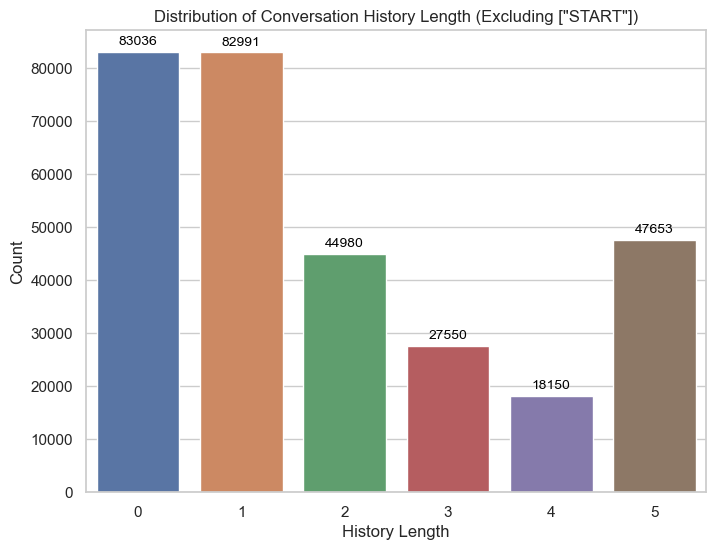

In [13]:
# Step 1: Correct history length for true zero-length histories (conversation_history == [] and response is not empty)
df['history_length'] = df.apply(lambda row: 0 if row['conversation_history'] == [] and row['response'].strip() != '' else row['history_length'], axis=1)

# Step 2: Exclude entries where conversation history is ["START"]
filtered_df = df[df['conversation_history'].apply(lambda x: x != ["START"])]

# Step 3: Plot the distribution of conversation history lengths
plt.figure(figsize=(8, 6))
sns_plot = sns.countplot(x='history_length', data=filtered_df)

# Add counts on top of each bar
for p in sns_plot.patches:
    sns_plot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                      textcoords='offset points')

# Add labels and title
plt.title('Distribution of Conversation History Length (Excluding ["START"])')
plt.xlabel('History Length')
plt.ylabel('Count')

plt.show()





- 0 = 45
- 1 = 38011
- 2 = 17430
- 3 = 9400

4 and 5 are unkonwn due to the rolling window which spikes up 5 but 4 would be lower than 18150


The high counts at 0 and 1 history length suggest that many conversations are either starting fresh or rely on minimal context, indicating that the chatbot needs to be adept at handling short interactions. The high 0 is due to all conversation starting at 0. The 45 discrepancy between 0 and 1 show that there are very minimal conversations that have absolutely no context. The spike at 5 history length likely reflects a rolling window effect, where conversations are capped at the most recent five turns. This ensures the chatbot focuses on the latest dialogue, optimizing response generation without handling overly long histories. 

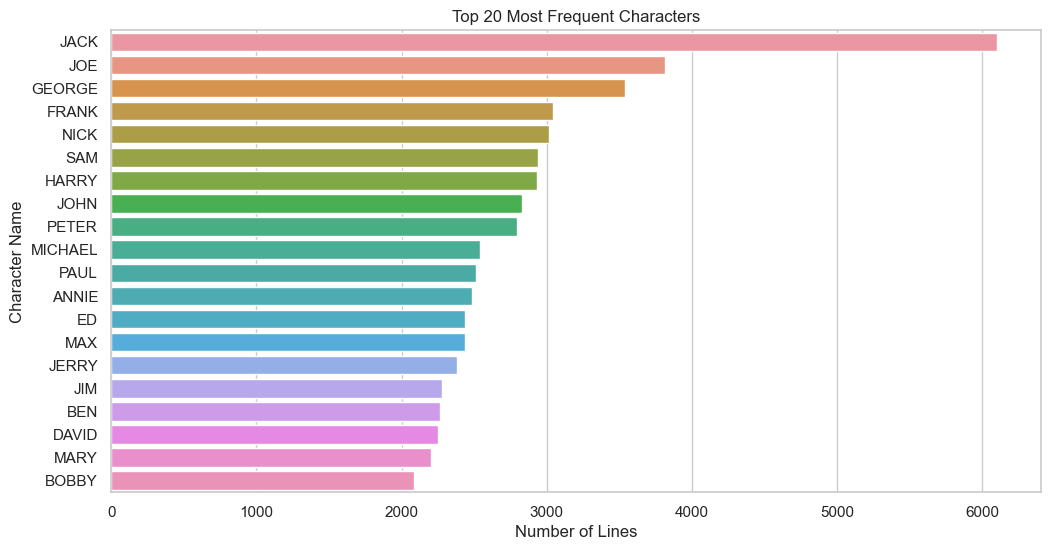

In [14]:
# Combine character_1 and character_2 to find most frequent characters
character_counts = pd.concat([df['character_1'], df['character_2']]).value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=character_counts.values, y=character_counts.index)
plt.title('Top 20 Most Frequent Characters')
plt.xlabel('Number of Lines')
plt.ylabel('Character Name')
plt.show()


Jack leads significantly with over 6,000 lines, followed by Joe and George, who both have under 4,000 lines. The distribution suggests that a few characters dominate the dataset, which may indicate that these characters are central to many conversations. The model will likely need to handle frequent interactions involving these high-volume characters, ensuring it can respond consistently and contextually to their dialogues.

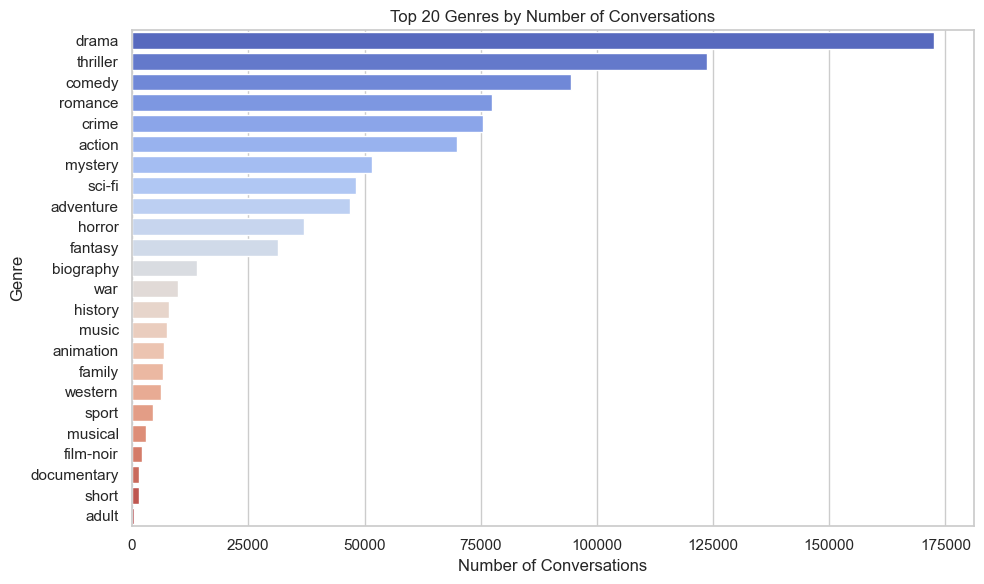

In [15]:
# Convert the genre strings to actual lists
df['genre'] = df['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 1: Explode the 'genre' column so each genre gets its own row
df_exploded = df.explode('genre')

# Step 2: Count the occurrences of each genre
#genre_counts = df_exploded['genre'].value_counts().head(20)  # Limit to top 20 genres
genre_counts = df_exploded['genre'].value_counts() # Limit to top 20 genres

# Step 3: Plot the genre distribution as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="coolwarm")
plt.title('Top 20 Genres by Number of Conversations')
plt.xlabel('Number of Conversations')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


Drama, thriller, and comedy dominate the list, with drama leading by a significant margin, followed by thriller. These three genres make up the majority of conversations, indicating that the dataset skews toward emotionally intense and suspenseful dialogue. The model will need to adapt to different tones and conversation styles, especially handling serious and suspenseful conversations more frequently than others. Other genres like romance and crime also have a notable presence, adding further variety to the interactions.

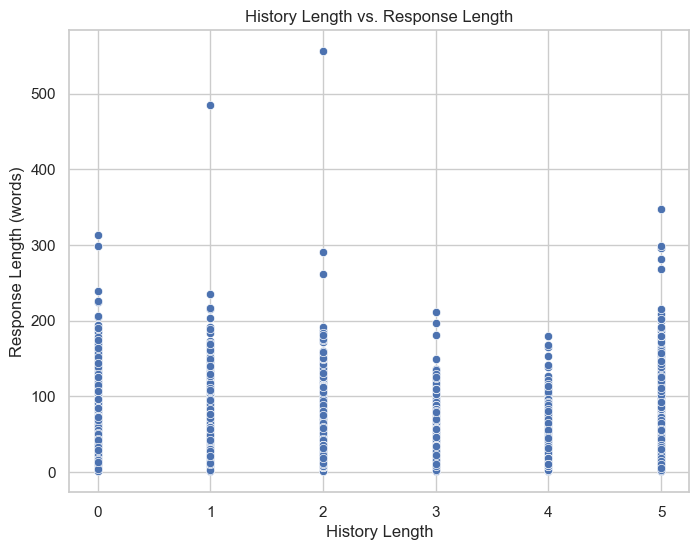

In [16]:
# Add a column for response length
df['response_length'] = df['response'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.scatterplot(x='history_length', y='response_length', data=df)
plt.title('History Length vs. Response Length')
plt.xlabel('History Length')
plt.ylabel('Response Length (words)')
plt.show()

# need to make sure this is words and not characters

This scatter plot shows the relationship between history length (number of previous turns) and response length (in words). Most responses, regardless of history length, tend to be concise, clustering below 100 words. However, there are outliers where responses exceed 300 or even 500 words, especially when the history length is 0 or 1. This suggests that while most responses are brief, some dialogues start with a long monologue or have more detailed responses, which may require the model to handle a wide range of response lengths effectively.

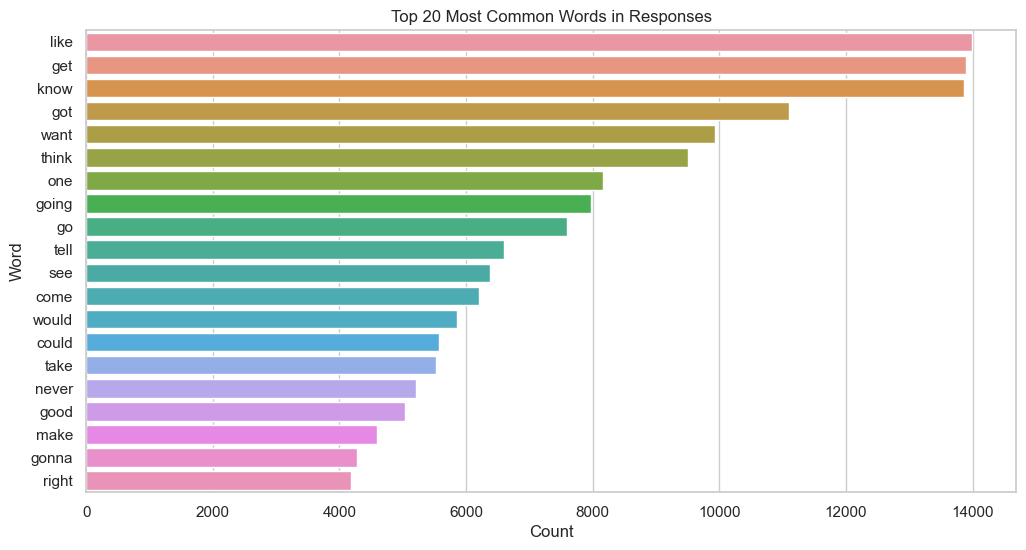

In [17]:
stop_words = set(stopwords.words('english'))

# Combine all responses into one string
all_responses = ' '.join(df['response'].tolist())

# Tokenize and remove stop words
words = [word.lower() for word in all_responses.split() if word.isalpha() and word.lower() not in stop_words]

word_counts = Counter(words).most_common(20)

# Convert to DataFrame for plotting
words_df = pd.DataFrame(word_counts, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=words_df)
plt.title('Top 20 Most Common Words in Responses')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


This bar chart displays the Top 20 most common words found in responses after removing stopwords. Words like "like," "get," and "know" are the most frequent, indicating that the conversations often involve casual, everyday dialogue. Many of the words, such as "want," "think," and "going," suggest that a significant portion of the conversations are centered around decision-making and opinions. The frequency of these basic verbs and pronouns highlights the conversational nature of the dataset.

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


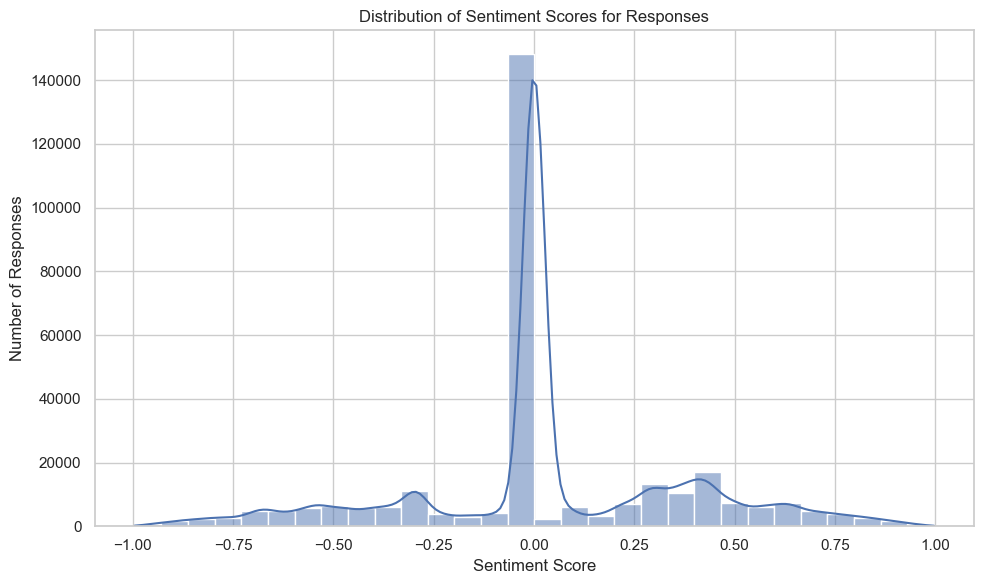

In [18]:
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each response
df['sentiment'] = df['response'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores for Responses')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Responses')
plt.tight_layout()
plt.show()


The data primarily deals with neutral dialogues. While strong emotions are present, they are less frequent, so the model should prioritize neutral sentiment understanding with occasional adjustments for emotional responses.

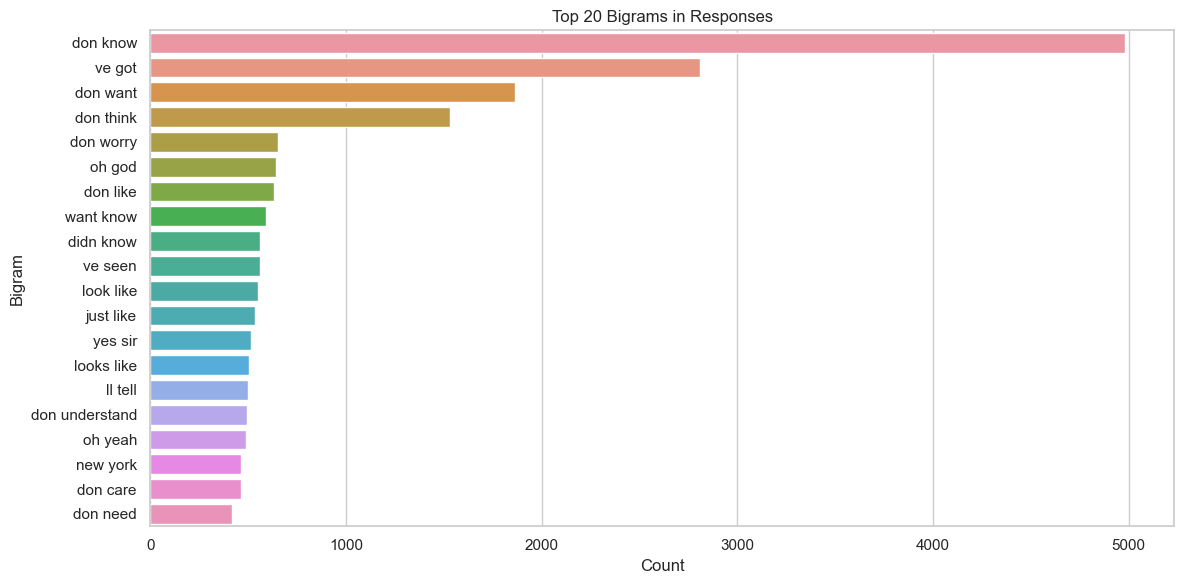

In [19]:
# Extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['response'])
bigram_counts = {word: count for word, count in zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)}

# Get the top 20 bigrams
top_bigrams = Counter(bigram_counts).most_common(20)

# Convert to DataFrame for plotting
bigram_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])

# Plot the top 20 bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='bigram', data=bigram_df)
plt.title('Top 20 Bigrams in Responses')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.tight_layout()
plt.show()


The frequent appearance of these common phrases suggests that the dataset is filled with casual, informal speech, which is typical for movie dialogues. The model will need to handle such conversational patterns, particularly those involving negative expressions and common phrases about knowledge or intention.

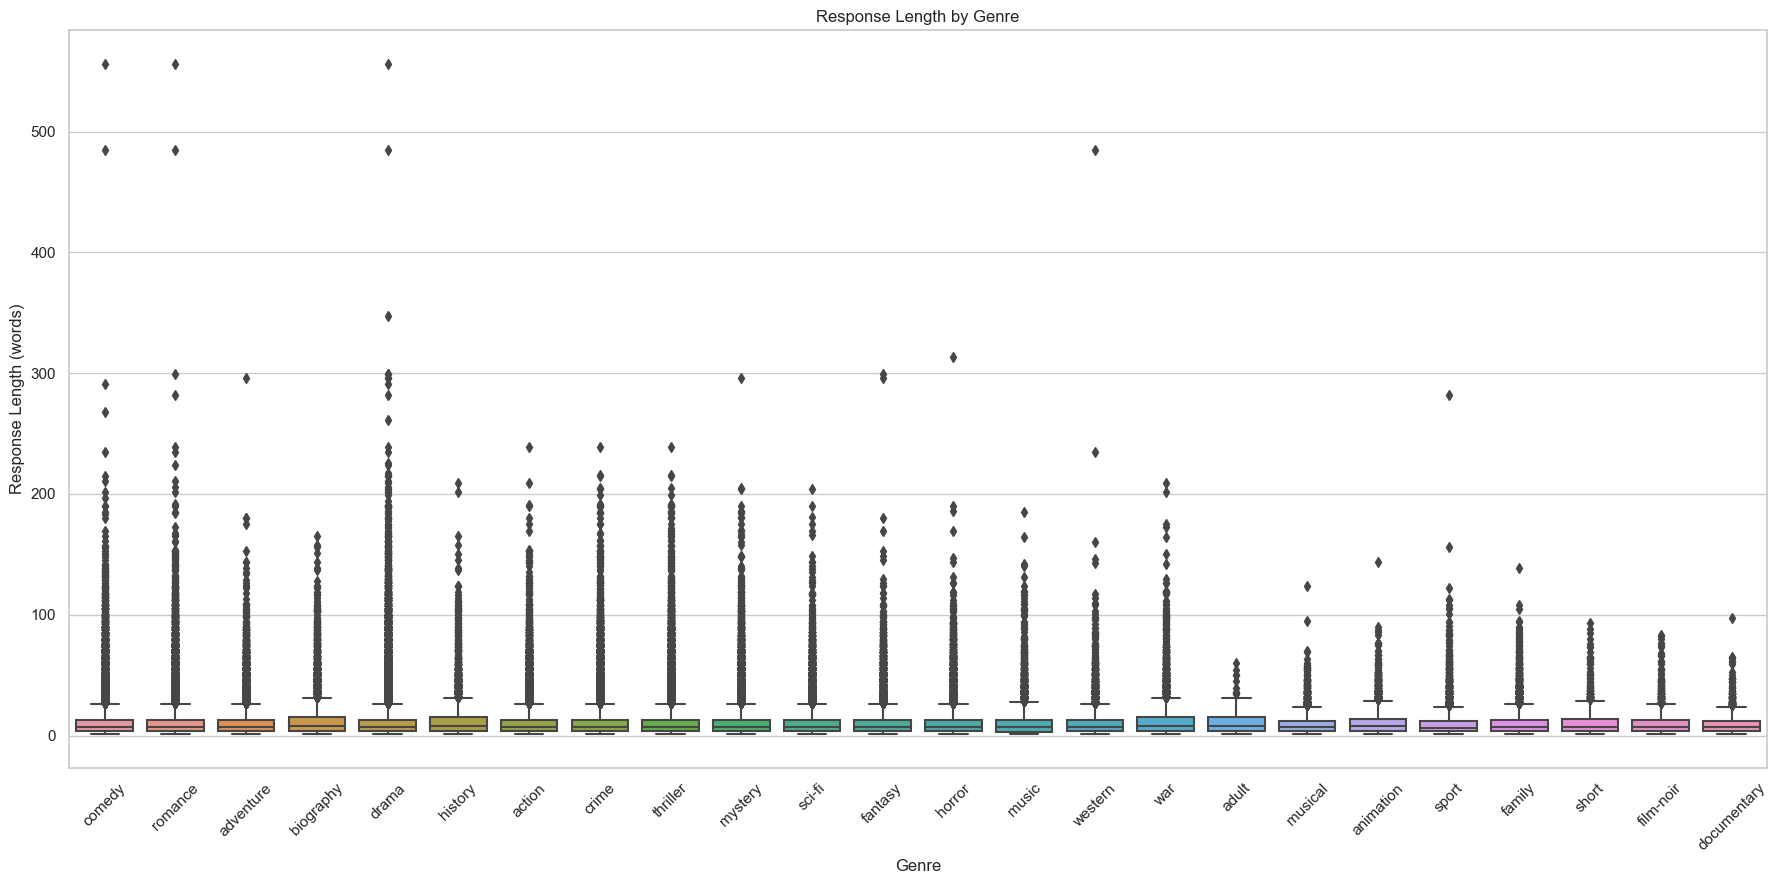

In [20]:
# Compare response lengths across genres
df_exploded = df.explode('genre')

plt.figure(figsize=(18, 9))
sns.boxplot(x='genre', y='response_length', data=df_exploded)
plt.title('Response Length by Genre')
plt.xlabel('Genre')
plt.ylabel('Response Length (words)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The model will need to handle both short responses (which dominate the dataset) and occasional long responses that vary by genre. The presence of long outliers in certain genres like drama and history suggests that more emotionally or narratively complex genres may require more detailed and nuanced responses.

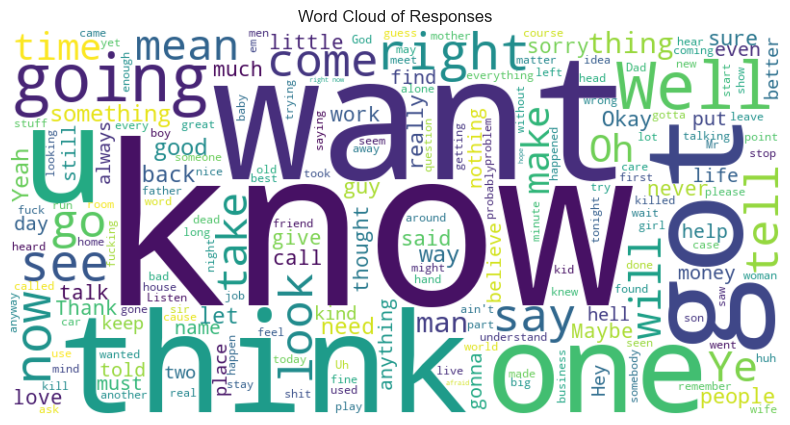

In [21]:
# Combine all responses into one string
all_responses = ' '.join(df['response'].tolist())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_responses)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Responses')
plt.show()


This word cloud highlights the most common words in responses, with terms like "know," "think," and "want" standing out. These words suggest that many dialogues involve expressions of thought, desire, or action. The chatbot will need to handle everyday conversational language, focusing on these common themes in dialogue.

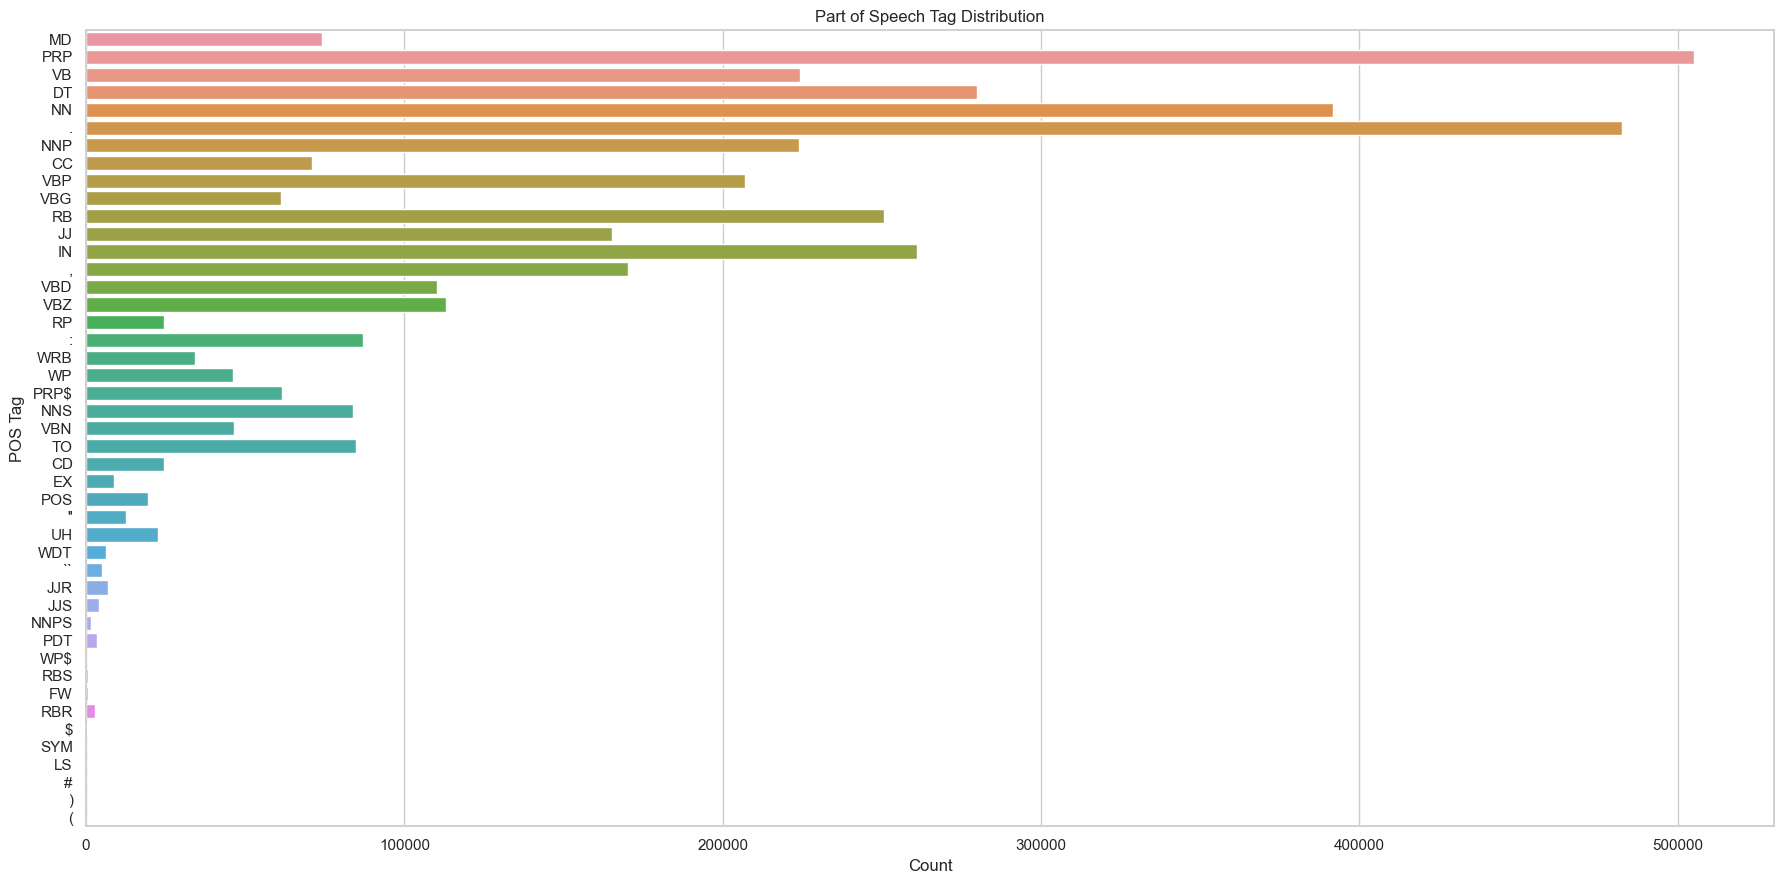

In [22]:
# Example of tagging one response
df['pos_tags'] = df['response'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

# Count the frequency of each POS tag
pos_counts = Counter([tag for tags in df['pos_tags'] for _, tag in tags])

# Convert to DataFrame for plotting
pos_df = pd.DataFrame(pos_counts.items(), columns=['POS', 'count'])

# Plot the POS tag distribution
plt.figure(figsize=(18, 9))
sns.barplot(x='count', y='POS', data=pos_df)
plt.title('Part of Speech Tag Distribution')
plt.xlabel('Count')
plt.ylabel('POS Tag')
plt.tight_layout()
plt.show()


The **Part of Speech (POS) Tag Distribution** graph highlights the dominance of nouns (NN), verbs (VB), and pronouns (PRP) in the dataset, suggesting a strong focus on actions and entities in the dialogues. Proper nouns (NNP) also appear frequently, indicating a focus on specific names and entities. The diversity of POS tags, including adjectives, conjunctions, and determiners, reflects the varied linguistic structure in the conversations.

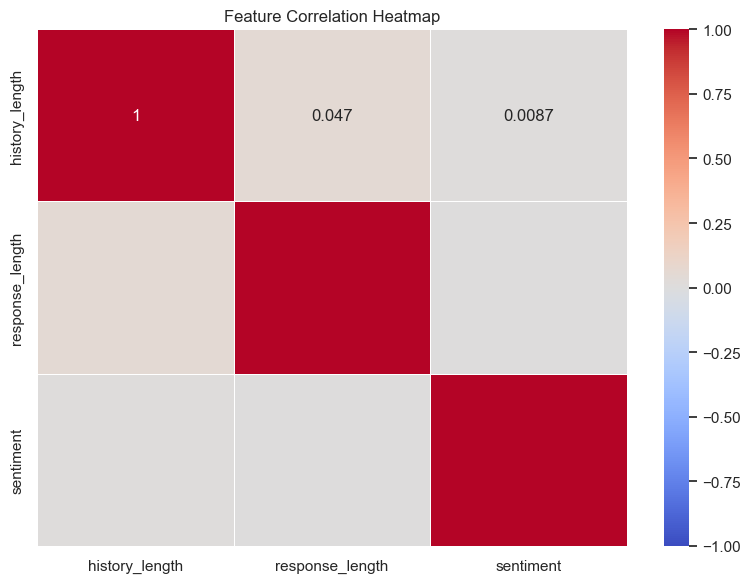

In [23]:
# Select numerical columns (including any other numeric features like sentiment, response length, etc.)
numerical_columns = ['history_length', 'response_length', 'sentiment']  # Add more columns as needed

# Compute the correlation matrix
corr_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


The Feature Correlation Heatmap shows weak correlations between the features in the dataset: history length, response length, and sentiment. The correlation between history length and response length is minimal at 0.047, indicating that longer conversation histories do not significantly influence response lengths. The correlation between history length and sentiment is nearly negligible at 0.0087, suggesting that sentiment is independent of conversation length. Overall, the heatmap indicates that these features are largely uncorrelated.

### Summary of EDA

Our analysis of the Cornell Movie-Dialog Corpus revealed several important insights regarding the structure and content of the dataset. The **conversation history length** showed that most dialogues are short, with 1 turn exchanges dominating, but a significant portion also had a rolling window of up to 5 turns, indicating some complexity in multi-turn conversations. The **POS tag distribution** demonstrated that the dataset is rich in nouns, verbs, and proper nouns, reflecting a focus on specific entities and actions in the dialogues. Moreover, the **word frequency and bigram analyses** highlighted the conversational nature of the dataset, with common informal phrases like "don’t know" and "got it" dominating the responses.

The **sentiment distribution** revealed that most responses are neutral, with a concentration around 0, indicating that dialogues are not highly polarized. Meanwhile, the **response lengths** varied across genres but generally tended to be short, with occasional longer responses scattered across different genres. The **feature correlation analysis** showed weak or negligible correlations between history length, response length, and sentiment, suggesting that these factors operate independently in the dataset.

### Best GenAI Model for This Task:

Given the nature of the dataset—dominated by short, informal conversations with a range of context lengths—a **Seq2Seq model** such as **T5 (Text-to-Text Transfer Transformer)** would be well-suited for this task. The model’s flexibility in handling multi-turn dialogues and generating coherent responses makes it a strong choice for this dataset. T5's ability to handle text generation, alongside its capacity to condition on conversation history, will allow the chatbot to maintain contextual relevance across multiple turns. Additionally, fine-tuning T5 on this dataset would help the model understand the conversational dynamics and nuances, such as sentiment shifts and genre-specific responses.

In summary, the **T5 model** offers the right balance of flexibility, generative capacity, and contextual understanding, making it the ideal choice for developing a conversational AI chatbot based on the Cornell Movie-Dialog Corpus.

## Modeling